In [1]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torch as torch

train_dir='/kaggle/input/quickdraw-10classes/quickdraw_small/train'
test_dir='/kaggle/input/quickdraw-10classes/quickdraw_small/test'

In [2]:
def load_images_from_folder(folder_path, class_to_idx, img_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        label = class_to_idx[class_name]
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = Image.open(img_path).convert('L')  
            img = img.resize(img_size)
            img_array = np.array(img, dtype=np.float32) / 255.0  
            img_tensor = torch.tensor(img_array).unsqueeze(0) 
            images.append(img_tensor)
            labels.append(label)
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)

train_classes = sorted(os.listdir(train_dir))
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(train_classes)}

train_images, train_labels = load_images_from_folder(train_dir, class_to_idx)
test_images, test_labels = load_images_from_folder(test_dir, class_to_idx)

print("Train shape:", train_images.shape, "Labels:", train_labels.shape)
print("Test shape:", test_images.shape, "Labels:", test_labels.shape)
print("Classes:", class_to_idx)

Train shape: torch.Size([16000, 1, 128, 128]) Labels: torch.Size([16000])
Test shape: torch.Size([4000, 1, 128, 128]) Labels: torch.Size([4000])
Classes: {'apple': 0, 'bicycle': 1, 'car': 2, 'cat': 3, 'chair': 4, 'clock': 5, 'dog': 6, 'fish': 7, 'house': 8, 'tree': 9}


In [18]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image
import torch

class QuickDrawDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images        
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]      
        label = self.labels[idx]
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
        if self.transform:
            img = self.transform(img)

        return img, label


from torchvision.transforms import v2

train_transform = v2.Compose([
    v2.RandomRotation(15),
    v2.RandomHorizontalFlip(),
    v2.Normalize(mean=[0.5], std=[0.5])   
])

test_transform = v2.Compose([
    v2.Normalize(mean=[0.5], std=[0.5])
])

In [20]:
batch_size = 64

train_ds = QuickDrawDataset(train_images, train_labels, transform=train_transform)
test_ds  = QuickDrawDataset(test_images, test_labels, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader), " Test batches:", len(test_loader))

Train batches: 250  Test batches: 63


In [34]:
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(1, 32, kernel_size=3, padding=1)),
    ('bn1', nn.BatchNorm2d(32)),
    ('relu1', nn.ReLU(inplace=True)),
    ('mp1', nn.MaxPool2d(2)),

    ('conv2', nn.Conv2d(32, 64, kernel_size=3, padding=1)),
    ('bn2', nn.BatchNorm2d(64)),
    ('relu2', nn.ReLU(inplace=True)),
    ('mp2', nn.MaxPool2d(2)),

    ('conv3', nn.Conv2d(64, 128, kernel_size=3, padding=1)),
    ('bn3', nn.BatchNorm2d(128)),
    ('relu3', nn.ReLU(inplace=True)),
    ('mp3', nn.MaxPool2d(2)),

    ('conv4', nn.Conv2d(128, 256, kernel_size=3, padding=1)),
    ('bn4', nn.BatchNorm2d(256)),
    ('relu4', nn.ReLU(inplace=True)),
    ('mp4', nn.MaxPool2d(2)),

    ('flatten', nn.Flatten()),
    ('linear', nn.Linear(256*8*8, 512)), 
    ('reluf', nn.ReLU(inplace=True)),
    ('dropout', nn.Dropout(0.4)),
    ('linearf', nn.Linear(512, 10))
]))

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

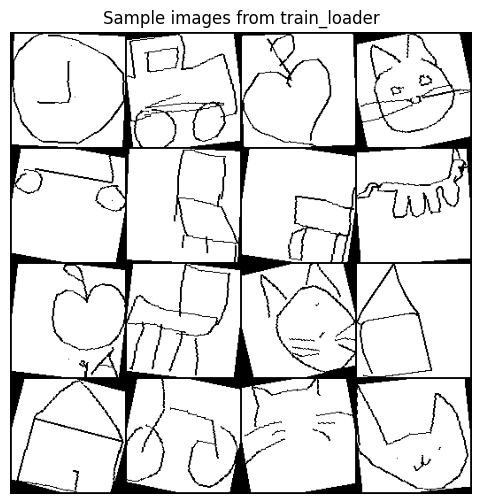

In [29]:
import matplotlib.pyplot as plt
import torchvision

images, labels = next(iter(train_loader))

grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True, padding=2)

npimg = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(6,6))
plt.imshow(npimg)  
plt.axis("off")
plt.title("Sample images from train_loader")
plt.show()

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 15

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train

    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= total_test
    test_acc = 100 * correct_test / total_test

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch [1/15] Train Loss: 1.4963, Train Acc: 59.22% | Test Loss: 0.5459, Test Acc: 82.67%
Epoch [2/15] Train Loss: 0.7196, Train Acc: 76.89% | Test Loss: 0.4770, Test Acc: 84.75%
Epoch [3/15] Train Loss: 0.6035, Train Acc: 81.11% | Test Loss: 0.3902, Test Acc: 88.53%
Epoch [4/15] Train Loss: 0.5572, Train Acc: 82.68% | Test Loss: 0.3913, Test Acc: 88.20%
Epoch [5/15] Train Loss: 0.4924, Train Acc: 84.45% | Test Loss: 0.4063, Test Acc: 87.50%
Epoch [6/15] Train Loss: 0.4595, Train Acc: 85.74% | Test Loss: 0.3369, Test Acc: 89.58%
Epoch [7/15] Train Loss: 0.4440, Train Acc: 86.17% | Test Loss: 0.3446, Test Acc: 90.42%
Epoch [8/15] Train Loss: 0.4187, Train Acc: 87.34% | Test Loss: 0.3219, Test Acc: 90.35%
Epoch [9/15] Train Loss: 0.3964, Train Acc: 87.54% | Test Loss: 0.3095, Test Acc: 91.00%
Epoch [10/15] Train Loss: 0.3723, Train Acc: 88.31% | Test Loss: 0.2837, Test Acc: 91.72%
Epoch [11/15] Train Loss: 0.3689, Train Acc: 88.47% | Test Loss: 0.2860, Test Acc: 91.95%
Epoch [12/15] Train

In [36]:
torch.save(model.state_dict(), "cnn_model.pth")
print("Model saved successfully!")

Model saved successfully!


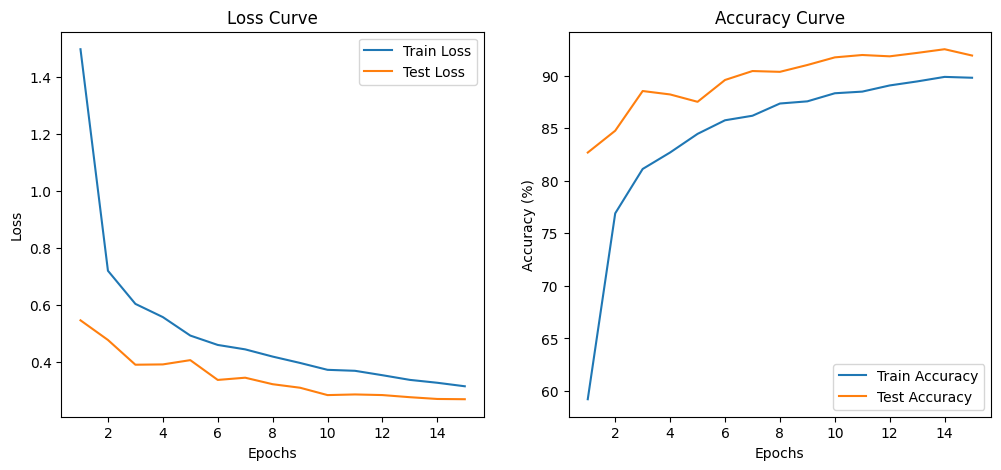

In [37]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)  
        _, predicted = torch.max(outputs, 1)       
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
test_loss /= total
test_acc = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.2692, Test Accuracy: 91.90%


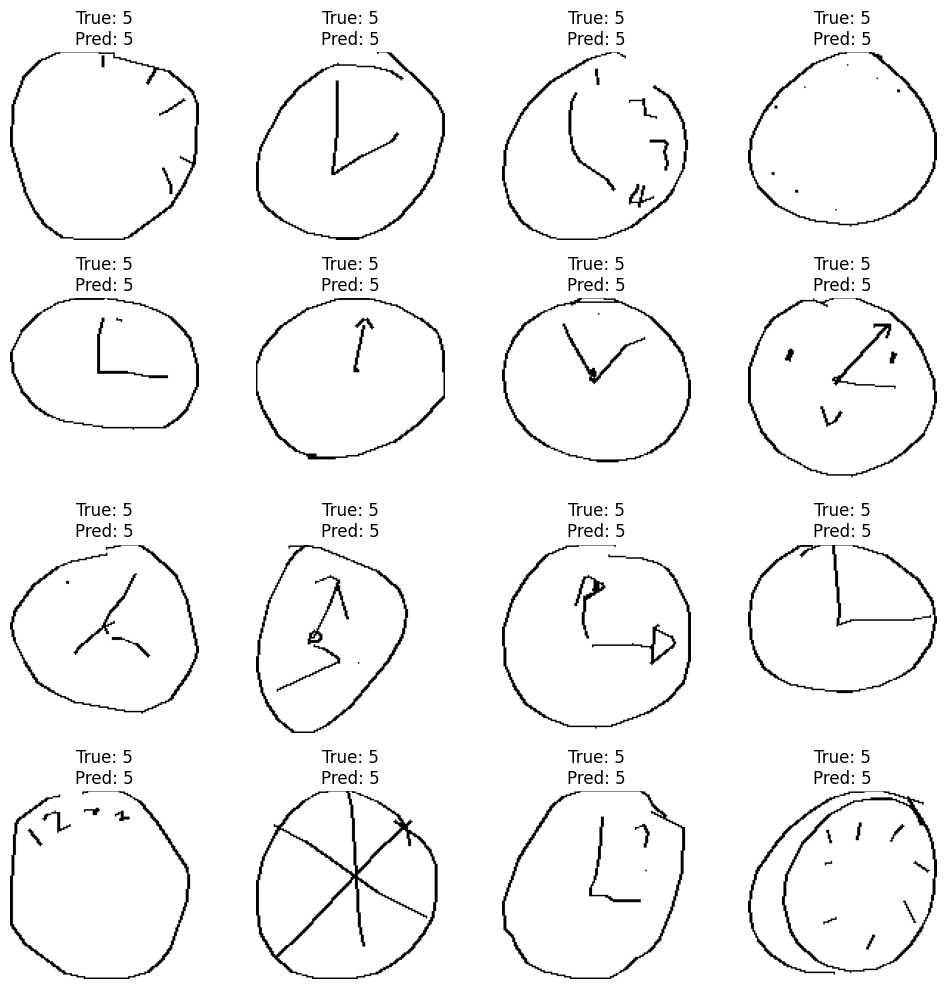

In [39]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = images[i].squeeze()  
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {labels[i].item()}\nPred: {preds[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()